In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv('insurance.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [12]:
df.shape

(1337, 7)

In [13]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [5]:
df.drop_duplicates(inplace=True)


In [3]:
df.dropna(inplace = True)

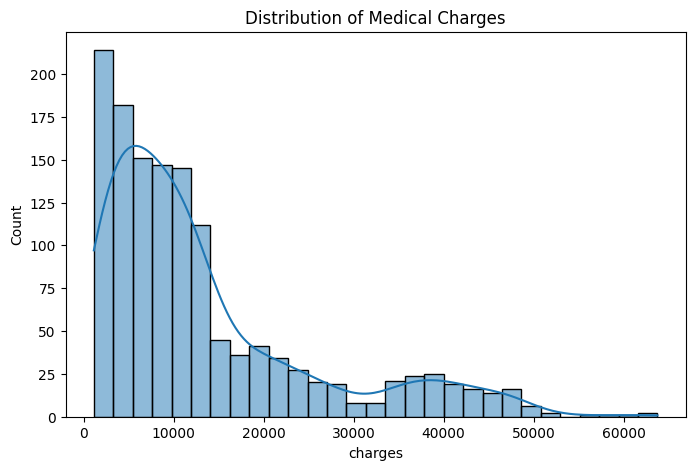

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Medical Charges")
plt.show()


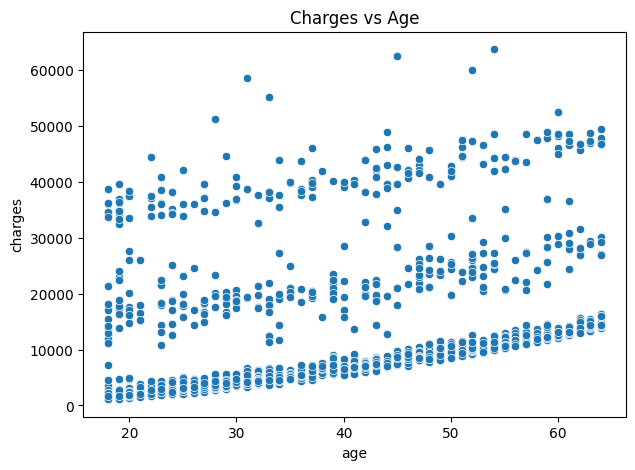

In [22]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["age"], y=df["charges"])
plt.title("Charges vs Age")
plt.show()


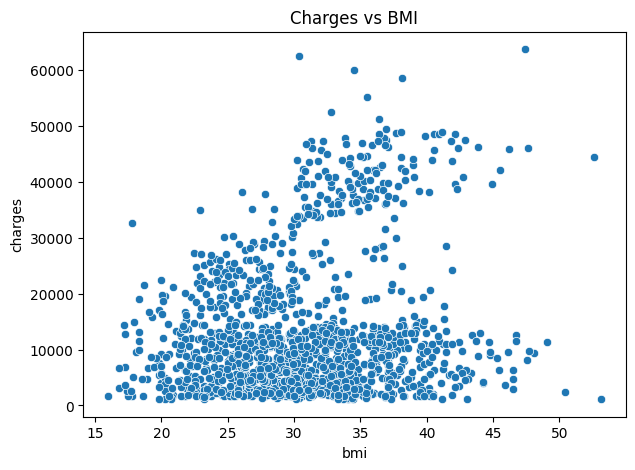

In [23]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["bmi"], y=df["charges"])
plt.title("Charges vs BMI")
plt.show()


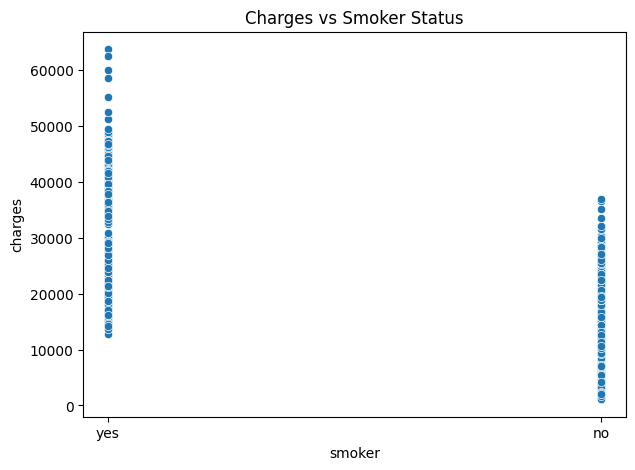

In [24]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["smoker"], y=df["charges"])
plt.title("Charges vs Smoker Status")
plt.show()


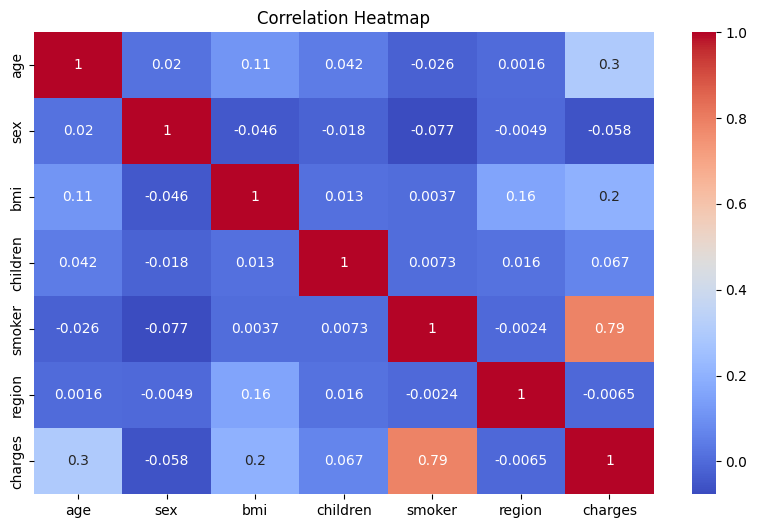

In [27]:
plt.figure(figsize=(10,6))
# Coverting categorical variables to numerical for correlation analysis
df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].map({'male':0,'female':1})
df_encoded['smoker'] = df_encoded['smoker'].map({'no':0,'yes':1})
df_encoded['region'] = df_encoded['region'].map({'northeast':0,'northwest':1,'southeast':2,'southwest':3})
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [28]:
# example
df["sex_male"] = (df["sex"] == "male").astype(int)
df["smoker_yes"] = (df["smoker"] == "yes").astype(int)
df = pd.get_dummies(df, columns=["region"], drop_first=True)
df = df.drop("sex", axis=1).drop("smoker", axis=1) 

In [29]:
y = df["charges"]
X = df.drop("charges", axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [35]:
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = (mean_squared_error(y_test, preds))**0.5
r2 = r2_score(y_test, preds)
print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")

MAE: 4177.045561036319, RMSE: 5956.342894363587, R2: 0.8069287081198012


In [36]:
y_pred_mean = np.repeat(y_train.mean(), len(y_test))
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_mean))
print("Your MAE:", mean_absolute_error(y_test, preds))


Baseline MAE: 9861.797880026175
Your MAE: 4177.045561036319


In [38]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_
})
# sort by absolute value of coefficients (descending)
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coefficient", ascending=False).drop(columns="abs_coefficient").reset_index(drop=True)
coef_df


,feature,coefficient
0,smoker_yes,23077.764593
1,region_southeast,-838.919616
2,region_southwest,-659.139752
3,children,533.009989
4,region_northwest,-391.761455
5,bmi,318.701441
6,age,248.210720
7,sex_male,-101.542054


In [39]:
# example for smoker
smoker_coef = coef_df.loc[coef_df.feature=="smoker_yes", "coefficient"].values[0]
print(f"Being a smoker increases predicted charges by about ${smoker_coef:,.0f} (all else equal).")


Being a smoker increases predicted charges by about $23,078 (all else equal).


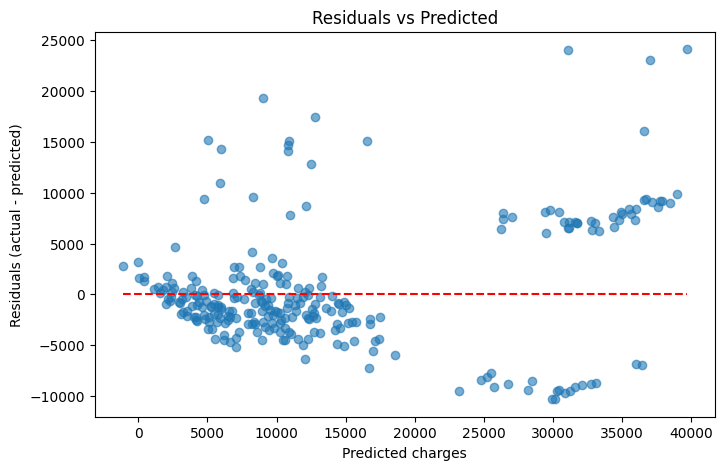

In [40]:
residuals = y_test - preds

plt.figure(figsize=(8,5))
plt.scatter(preds, residuals, alpha=0.6)
plt.hlines(0, xmin=preds.min(), xmax=preds.max(), colors="r", linestyles="--")
plt.xlabel("Predicted charges")
plt.ylabel("Residuals (actual - predicted)")
plt.title("Residuals vs Predicted")
plt.show()


In [44]:
import joblib, json
joblib.dump(model, "insurance_model.pkl")
json.dump(list(X.columns), open("columns.json", "w"))